# Prediccion de movimiento realizado por usuario
El proyecto consta en hacer un modelo de inteligencia artificial que clasifique quien fue el usuario que realizo el movimiento. En este caso los movimientos realizados fueron 3 basados en movimientos de basket: pase, tiro y pique. \
Los movimientos fueron capturados con una app que grababa los movimientos que se realizan con el celular.

Durante el proyecto se llego a la conclusion que al probar el modelo final con datos no vistos anteriormente este nos da una asertividad (acuracy) del 51% (acertara 51 veces de cada 100) por lo cual se analizo las predicciones con una matriz de confusion, en ella se pudo observar que el modelo tiende a predecir mayormente a pase y a pique. 

Porque sucede esto? \
Esto puede ser ya que puede estar aprendiendo de los patrones de los archivos proporcionados, ya que son muchas observaciones de pocos archivos, sumado a que la cantidad de datos estan desbalanceados, ya que hay solamente hay 3.000 datos en pase, y 2.400 en tiro y pique

Como mejorarlo? \
Agregando datos podria mejorar este mismo, al tener mas variaciones para el aprendizaje del modelo, este podria encontrar algun dato clave para la mejora de la prediccion. En las curvas de aprendizaje se pudo observar tendencia a incrementar la acertividad cuando entrenamos el modelo con mas datos.

# Hacemos una importacion de librerias

In [1]:
import pandas as pd
import numpy as np
import os
from collections import deque

# graficos
import matplotlib.pyplot as plt
import seaborn as sns

# modelos
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, cross_validate, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

# Para calcular las curvas de aprendizaje
from sklearn.model_selection import learning_curve

In [2]:
direccion_archivos = 'C:\\Users\\gaspa\\OneDrive\\Escritorio\\Facu\\NLP\\Basket\\'
archivos_raw = os.listdir(direccion_archivos)
archivos = {'pase': [archivo for archivo in archivos_raw if 'pase' in archivo],
           'tiro': [archivo for archivo in archivos_raw if 'tiro' in archivo],
           'pique': [archivo for archivo in archivos_raw if 'pique' in archivo]}
archivos

{'pase': ['fede-pase.csv',
  'firmani-pase.csv',
  'franco-pase.csv',
  'jm-pase.csv',
  'lorenzo-pase.csv',
  'mauri-pase.csv',
  'nahir-pase.csv',
  'Nico-pase.csv',
  'rocio-pase.csv',
  'salvi-pase.csv',
  'tania-pase.csv'],
 'tiro': ['fede-tiro.csv',
  'firmani-tiro.csv',
  'jm-tiro.csv',
  'lorenzo-tiro.csv',
  'mauri-tiro.csv',
  'nahir-tiro.csv',
  'nico-tiro.csv',
  'rocio-tiro.csv',
  'salvi-tiro.csv',
  'tania-tiro.csv'],
 'pique': ['fede-pique.csv',
  'firmani-pique.csv',
  'franco-pique.csv',
  'jm-pique.csv',
  'lorenzo-pique.csv',
  'mauri-pique.csv',
  'nahir-pique.csv',
  'nico-pique.csv',
  'rocio-pique.csv',
  'salvi-pique.csv',
  'tania-pique.csv']}

# Hacemos la extraccion de los datos de test

In [3]:
import random

seleccionados = {}
for movimiento in archivos:
    if archivos[movimiento]:
        elegido = random.choice(archivos[movimiento])
        seleccionados[movimiento] = [elegido]
        archivos[movimiento].remove(elegido)
seleccionados

{'pase': ['Nico-pase.csv'],
 'tiro': ['nahir-tiro.csv'],
 'pique': ['nico-pique.csv']}

# Hacemos un DataFrame extrayendo los datos de los archivos

In [96]:
def separador_acciones(direccion_archivos, archivos, accion):
    dataframes = []
    lista = deque(maxlen=1)
    for archivo in archivos:
        df_archivo = pd.read_csv(f'{direccion_archivos}{archivo}')    
        for _, row in df_archivo.iterrows():
            lista.append(row)            
            if len(lista) == 1:
                nueva_fila = {
                    'gFx': [lista[0]['gFx']], 'gFy': [lista[0]['gFy']], 'gFz': [lista[0]['gFz']],
                    'ax': [lista[0]['ax']], 'ay': [lista[0]['ay']], 'az': [lista[0]['az']],
                    'wx': [lista[0]['wx']], 'wy': [lista[0]['wy']], 'wz': [lista[0]['wz']],
                    'archivo': archivo
                }
                df_fila = pd.DataFrame(nueva_fila)
                df_fila['gFy'] = pd.to_numeric(df_fila['gFy'], errors='coerce')
                # Elimino el NaN
                df_fila = df_fila.dropna(subset=['gFy'])
                dataframes.append(df_fila)
                
    dataframes = pd.concat(dataframes, ignore_index=True)
    if 'Unnamed: 10' in dataframes.columns:
        dataframes = dataframes.drop(['Unnamed: 10'], axis=1)
    dataframes['movimiento'] = accion    
    return dataframes


def creador_dataframe_acciones(archivos, direccion_archivos):
    acciones = ['pique', 'pase', 'tiro']
    lista_dataframes_separados = []
    for accion in acciones:
        lista_dataframes_separados.append(separador_acciones(direccion_archivos, archivos[accion], accion))
    return pd.concat(lista_dataframes_separados, ignore_index=True)

dataframe_raw = creador_dataframe_acciones(archivos, direccion_archivos)
dataframe_raw = dataframe_raw.sample(frac=1).reset_index(drop=True)
dataframe_raw.to_csv('dataframe_basket.csv')
dataframe_raw


,gFx,gFy,gFz,ax,ay,az,wx,wy,wz,archivo,movimiento
0,-0.0347,0.3870,0.8008,-0.4061,-4.9095,4.7343,1.5630,0.0664,0.1367,franco-pique.csv,pique
1,-0.0286,0.8400,-0.5569,0.2289,-0.1776,0.1072,-0.2621,0.0643,0.0137,jm-tiro.csv,tiro
2,1.0211,0.8482,-0.4989,3.4227,1.8955,0.4020,3.3064,-3.1668,-0.2330,mauri-pase.csv,pase
3,-0.2160,0.6490,0.7870,-0.4900,-0.5000,-0.5400,0.2900,-0.0900,0.7000,firmani-pique.csv,pique
4,-0.0238,-0.6279,2.5197,8.4282,-16.1167,14.3540,-0.9907,-0.2541,0.0470,rocio-pique.csv,pique
...,...,...,...,...,...,...,...,...,...,...,...
8138,0.3750,1.0367,0.4615,1.5561,1.5047,-5.7142,-4.8474,0.0149,-2.1072,nico-tiro.csv,tiro
8139,-0.3866,0.5845,1.0626,-0.4943,0.0769,0.2419,0.2189,-0.6749,-0.9745,salvi-tiro.csv,tiro
8140,0.0014,0.8758,0.4395,0.8224,1.1916,-0.8007,0.0117,0.3189,-0.0778,fede-pique.csv,pique
8141,0.1055,1.5576,-1.5111,2.8227,-4.2739,-9.6477,3.9311,0.7177,0.3276,salvi-pase.csv,pase


In [5]:
dataframe_test = creador_dataframe_acciones(seleccionados, direccion_archivos)
dataframe_test = dataframe_test.sample(frac=1).reset_index(drop=True)
dataframe_test

,gFx,gFy,gFz,ax,ay,az,wx,wy,wz,archivo,movimiento
0,0.4904,0.6705,0.7063,-0.3542,1.1046,1.4365,0.2706,0.1986,0.0481,nico-pique.csv,pique
1,0.3780,0.5780,0.7106,-0.9647,-2.8599,8.4189,0.3651,-4.3793,-1.8780,nico-pique.csv,pique
2,0.0100,-0.1490,0.1270,3.3200,-7.4000,-1.5000,-6.0800,-3.2900,0.0700,nahir-tiro.csv,tiro
3,0.4219,0.6641,0.3313,-1.2309,2.2652,-0.0571,0.2030,2.0576,0.4178,nico-pique.csv,pique
4,-0.0290,1.0951,0.0578,-4.4717,1.8948,0.2266,-0.9923,1.3313,0.2779,Nico-pase.csv,pase
...,...,...,...,...,...,...,...,...,...,...,...
676,0.3987,0.6475,0.5369,-0.6717,1.6803,-1.3317,0.0341,0.2266,0.1852,nico-pique.csv,pique
677,0.3780,0.5780,0.7106,2.7243,-3.3646,4.8659,0.3651,-4.3793,-1.8780,nico-pique.csv,pique
678,0.5166,0.8974,0.3028,0.6343,0.2448,0.8854,0.1494,0.4034,0.1889,Nico-pase.csv,pase
679,-0.3017,-0.9394,-2.1784,-2.2647,-4.5390,-13.0873,-2.7028,1.9648,0.1458,nico-pique.csv,pique


# Analasis Exploratorio de los datos

In [95]:
dataframe_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8143 entries, 0 to 8142
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   gFx         8143 non-null   float64
 1   gFy         8143 non-null   float64
 2   gFz         8143 non-null   float64
 3   ax          8143 non-null   float64
 4   ay          8143 non-null   float64
 5   az          8143 non-null   float64
 6   wx          8143 non-null   float64
 7   wy          8143 non-null   float64
 8   wz          8143 non-null   float64
 9   archivo     8143 non-null   object 
 10  movimiento  0 non-null      float64
dtypes: float64(10), object(1)
memory usage: 699.9+ KB


Aqui podemos observar que no hay datos nulos, tenemos las columnasarchivo y movimiento con strings, y las demas con floats. 

In [80]:
dataframe_raw.describe()

,gFx,gFy,gFz,ax,ay,az,wx,wy,wz
count,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000
mean,0.004083,0.277606,0.120100,-0.038492,-1.050578,-0.099316,0.078966,0.141127,-0.174447
std,0.565339,0.680526,1.066481,3.304154,3.761591,5.585306,2.775568,2.568196,1.514213
min,-2.798300,-3.902600,-4.835100,-24.021000,-34.132100,-40.420000,-12.914300,-16.807000,-13.510000
25%,-0.230400,0.025200,-0.499800,-0.780400,-1.196800,-0.905500,-0.927700,-0.649450,-0.651500
50%,-0.018300,0.459000,0.308500,-0.038500,-0.100700,0.050600,-0.014200,0.030000,-0.046600
75%,0.191600,0.747600,0.809200,0.595700,0.300000,1.300600,0.732100,0.837400,0.325700
max,5.410700,2.132300,5.066000,33.440500,10.925800,26.197700,15.778300,12.584400,9.061700


In [82]:
dataframe_raw.shape

(8143, 11)

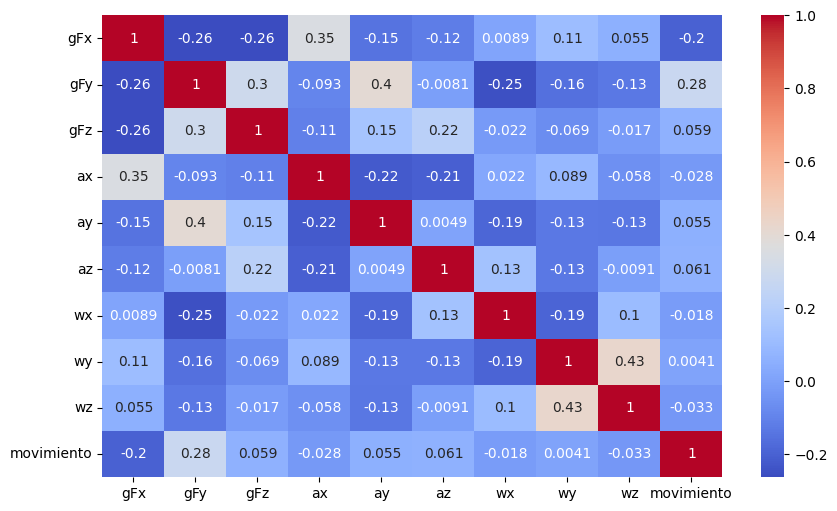

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt
df_analisis = dataframe_raw.drop(['archivo'], axis=1)
df_analisis['movimiento'] = df_analisis['movimiento'].map({'pique': 0, 'pase': 1, 'tiro': 2})
plt.figure(figsize=(10, 6))
sns.heatmap(df_analisis.corr(), annot=True, cmap='coolwarm')
plt.show()

En el grafico de correlacion podemos observar que las relaciones entre movimiento y las x, son bajos, siendo el mas grande 0.28, teniendo 3 que estan entre 0.061 y 0 y los 4 restantes por debajo de 0. Esto puede influir en el aprendizaje del modelo ya que puede influir en que no encuentre una buena manera de explicar el target.

# Hacemos las ventanas temporales

In [6]:
from collections import deque
def separador_acciones(dataframe):
        dataframes = []
        lista = deque(maxlen=3)
        for _, row in dataframe.iterrows():
            lista.append(row)
            if len(lista) == 3:
                nueva_fila = {
                    'archivo': [lista[0]['archivo']], 'gFx_i': [lista[0]['gFx']], 'gFy_i': [lista[0]['gFy']], 'gFz_i': [lista[0]['gFz']],
                    'ax_i': [lista[0]['ax']], 'ay_i': [lista[0]['ay']], 'az_i': [lista[0]['az']],
                    'wx_i': [lista[0]['wx']], 'wy_i': [lista[0]['wy']], 'wz_i': [lista[0]['wz']],
                    'gFx_m': lista[1]['gFx'], 'gFy_m': [lista[1]['gFy']], 'gFz_m': [lista[1]['gFz']],
                    'ax_m': [lista[1]['ax']], 'ay_m': [lista[1]['ay']], 'az_m': [lista[1]['az']],
                    'wx_m': [lista[1]['wx']], 'wy_m': [lista[1]['wy']], 'wz_m': [lista[1]['wz']],
                    'gFx_f': [lista[2]['gFx']], 'gFy_f': [lista[2]['gFy']], 'gFz_f': [lista[2]['gFz']],
                    'ax_f': [lista[2]['ax']], 'ay_f': [lista[2]['ay']], 'az_f': [lista[2]['az']],
                    'wx_f': [lista[2]['wx']], 'wy_f': [lista[2]['wy']], 'wz_f': [lista[2]['wz']]
                }
                # Aniade la columna 'movimiento' solamente si se envio una y
                if 'movimiento' in dataframe.columns:
                    nueva_fila['movimiento'] = lista[0]['movimiento']

                df_fila = pd.DataFrame(nueva_fila)
                df_fila[['gFy_i', 'gFy_m', 'gFy_f']] = df_fila[['gFy_i', 'gFy_m', 'gFy_f']].apply(pd.to_numeric, errors='coerce')
                df_fila = df_fila.dropna(subset=['gFy_i', 'gFy_m', 'gFy_f'])
                dataframes.append(df_fila)
        return dataframes

In [7]:
def separador_archivos(X, y=None):
    col_archivos = 'archivo'
    archivos = X[col_archivos].unique()
    lista_dataframes_separados = []

    # Aniade 'movimiento' solamente si le enviamos la y,  esto seria en el entrenamiento
    if y is not None:
        X = X.copy()
        X['movimiento'] = y

    for archivo in archivos:
        df_filtered = X[X[col_archivos] == archivo]
        dataframes_for_combination = separador_acciones(df_filtered)
        lista_dataframes_separados.extend(dataframes_for_combination)

    # Concatena todos los dataframes modificados
    X_transformed = pd.concat(lista_dataframes_separados, ignore_index=True).sample(frac=1).reset_index(drop=True)

    # Separa 'movimiento' solo si existe en el dataframe modificado
    if 'movimiento' in X_transformed.columns:
        y_transformed = X_transformed['movimiento']
        return X_transformed.drop(columns=['movimiento']), y_transformed
    else:
        return X_transformed, None

In [8]:
X, y = separador_archivos(dataframe_raw.drop(columns=['movimiento']), dataframe_raw['movimiento'])

X_test, y_test = separador_archivos(dataframe_test.drop(columns=['movimiento']), dataframe_test['movimiento'])

In [9]:
X.head()

,archivo,gFx_i,gFy_i,gFz_i,ax_i,ay_i,az_i,wx_i,wy_i,wz_i,...,wz_m,gFx_f,gFy_f,gFz_f,ax_f,ay_f,az_f,wx_f,wy_f,wz_f
0,nahir-pase.csv,0.8480,-0.2520,-0.6740,-1.7000,-3.2300,6.3100,0.3600,-0.9600,-1.2800,...,0.3600,0.0400,-0.6130,-0.4390,0.8800,-3.2400,1.9300,-1.6100,1.2600,2.1300
1,fede-pase.csv,0.1758,0.6901,0.7097,0.1545,0.3059,-0.9055,3.6932,-5.6317,-1.2933,...,1.6500,-0.2569,0.5816,0.7312,0.1353,-0.2215,0.1189,0.2589,-1.2961,-0.0480
2,fede-tiro.csv,-0.1241,0.5574,0.8768,0.2586,0.1703,0.0617,0.4122,-0.0274,-0.0054,...,0.1437,-0.3090,-1.3583,1.4183,-0.4881,-6.1733,-1.9187,7.9564,-0.0657,0.0191
3,tania-tiro.csv,-0.1824,-1.3673,1.2509,-5.2126,1.5408,7.8977,3.8803,1.4576,-0.0945,...,0.2011,0.1215,0.9887,0.2503,0.0000,0.0000,0.0000,0.6063,-2.1768,-1.3738
4,tania-pase.csv,0.3271,0.9314,0.1546,0.2390,-0.2080,0.1637,0.7787,-1.9116,-1.5048,...,-0.6730,-0.9027,0.6614,0.3983,-5.8532,-0.1460,7.3440,0.0670,-0.4830,0.8206


In [64]:
X_test = X_test.drop(['archivo'], axis=1)
X_test.head()

,gFx_i,gFy_i,gFz_i,ax_i,ay_i,az_i,wx_i,wy_i,wz_i,gFx_m,...,wz_m,gFx_f,gFy_f,gFz_f,ax_f,ay_f,az_f,wx_f,wy_f,wz_f
0,0.3020,-0.4780,-0.952,0.2100,-1.0200,1.7700,2.0900,-3.3000,-3.4200,1.1470,...,-0.6500,0.4130,0.3700,0.7990,-1.3900,-13.7700,-7.8900,6.8600,-2.7100,-0.8400
1,0.1415,0.5994,0.593,-0.9647,-2.8599,8.4189,0.3651,-4.3793,-1.8780,0.4223,...,0.2631,0.0577,-1.3961,-1.1012,-4.3853,-1.4825,9.1379,9.3018,-1.3428,0.0332
2,-0.2717,1.0689,-0.368,-1.8658,0.5222,-2.5528,-0.0702,-0.1078,-0.5696,-0.3964,...,0.4885,0.7702,0.4559,0.6765,0.0000,0.0000,0.0000,-0.5409,-5.9547,-2.8234
3,1.1130,-0.4490,1.252,-8.5100,-3.0100,-7.8600,1.5800,-1.2700,-0.3700,0.4050,...,1.9300,-0.0160,-0.7440,-0.7140,-0.4500,-0.1900,0.4200,0.0900,-0.3300,-0.1100
4,0.0530,-1.0760,-0.558,0.4600,3.4800,1.8100,-0.3500,2.8300,3.8400,-0.0370,...,-0.2600,0.3760,-0.7700,-1.0630,1.5200,1.5000,4.1500,-2.6400,3.0000,1.8000


In [11]:
y

0        pase
1        pase
2        tiro
3        tiro
4        pase
        ...  
8080    pique
8081     tiro
8082     pase
8083    pique
8084     tiro
Name: movimiento, Length: 8085, dtype: object

In [13]:
map_labels = {'pique': 0, 'pase': 1, 'tiro': 2}
y_test = y_test.map(map_labels)
y_test

0      2
1      0
2      1
3      2
4      2
      ..
670    2
671    0
672    0
673    0
674    0
Name: movimiento, Length: 675, dtype: int64

In [14]:
df = pd.concat([X, y], axis=1)
df

,archivo,gFx_i,gFy_i,gFz_i,ax_i,ay_i,az_i,wx_i,wy_i,wz_i,...,gFx_f,gFy_f,gFz_f,ax_f,ay_f,az_f,wx_f,wy_f,wz_f,movimiento
0,nahir-pase.csv,0.8480,-0.2520,-0.6740,-1.7000,-3.2300,6.3100,0.3600,-0.9600,-1.2800,...,0.0400,-0.6130,-0.4390,0.8800,-3.2400,1.9300,-1.6100,1.2600,2.1300,pase
1,fede-pase.csv,0.1758,0.6901,0.7097,0.1545,0.3059,-0.9055,3.6932,-5.6317,-1.2933,...,-0.2569,0.5816,0.7312,0.1353,-0.2215,0.1189,0.2589,-1.2961,-0.0480,pase
2,fede-tiro.csv,-0.1241,0.5574,0.8768,0.2586,0.1703,0.0617,0.4122,-0.0274,-0.0054,...,-0.3090,-1.3583,1.4183,-0.4881,-6.1733,-1.9187,7.9564,-0.0657,0.0191,tiro
3,tania-tiro.csv,-0.1824,-1.3673,1.2509,-5.2126,1.5408,7.8977,3.8803,1.4576,-0.0945,...,0.1215,0.9887,0.2503,0.0000,0.0000,0.0000,0.6063,-2.1768,-1.3738,tiro
4,tania-pase.csv,0.3271,0.9314,0.1546,0.2390,-0.2080,0.1637,0.7787,-1.9116,-1.5048,...,-0.9027,0.6614,0.3983,-5.8532,-0.1460,7.3440,0.0670,-0.4830,0.8206,pase
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8080,rocio-pique.csv,-0.5541,0.3717,0.6881,-4.4063,-3.0636,0.6071,-1.5579,3.0817,-0.2919,...,-0.1161,0.7457,-3.7869,-1.0939,2.8766,-25.3626,-6.8358,-4.1228,-0.5685,pique
8081,fede-tiro.csv,0.0566,0.5655,1.1129,0.4315,-0.6342,0.5655,-0.0341,0.1974,0.1735,...,0.5899,0.8182,-0.4834,1.3754,0.4860,2.1477,-3.7071,2.7732,-0.8928,tiro
8082,jm-pase.csv,-0.0626,1.0141,0.6152,-0.6709,0.8199,-1.3432,0.2917,-0.1051,0.4538,...,-0.0055,0.7864,0.5902,0.1405,-0.0716,0.0369,1.9116,-0.5213,-0.4016,pase
8083,lorenzo-pique.csv,1.5802,-2.0279,-0.5131,-0.7576,-0.7137,1.3437,9.6196,5.6343,5.6733,...,-0.2347,0.6765,-1.0674,-0.2402,0.1451,0.6614,0.4854,-0.4147,0.5255,pique


In [15]:
df['movimiento'] = df['movimiento'].map(map_labels)
df

,archivo,gFx_i,gFy_i,gFz_i,ax_i,ay_i,az_i,wx_i,wy_i,wz_i,...,gFx_f,gFy_f,gFz_f,ax_f,ay_f,az_f,wx_f,wy_f,wz_f,movimiento
0,nahir-pase.csv,0.8480,-0.2520,-0.6740,-1.7000,-3.2300,6.3100,0.3600,-0.9600,-1.2800,...,0.0400,-0.6130,-0.4390,0.8800,-3.2400,1.9300,-1.6100,1.2600,2.1300,1
1,fede-pase.csv,0.1758,0.6901,0.7097,0.1545,0.3059,-0.9055,3.6932,-5.6317,-1.2933,...,-0.2569,0.5816,0.7312,0.1353,-0.2215,0.1189,0.2589,-1.2961,-0.0480,1
2,fede-tiro.csv,-0.1241,0.5574,0.8768,0.2586,0.1703,0.0617,0.4122,-0.0274,-0.0054,...,-0.3090,-1.3583,1.4183,-0.4881,-6.1733,-1.9187,7.9564,-0.0657,0.0191,2
3,tania-tiro.csv,-0.1824,-1.3673,1.2509,-5.2126,1.5408,7.8977,3.8803,1.4576,-0.0945,...,0.1215,0.9887,0.2503,0.0000,0.0000,0.0000,0.6063,-2.1768,-1.3738,2
4,tania-pase.csv,0.3271,0.9314,0.1546,0.2390,-0.2080,0.1637,0.7787,-1.9116,-1.5048,...,-0.9027,0.6614,0.3983,-5.8532,-0.1460,7.3440,0.0670,-0.4830,0.8206,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8080,rocio-pique.csv,-0.5541,0.3717,0.6881,-4.4063,-3.0636,0.6071,-1.5579,3.0817,-0.2919,...,-0.1161,0.7457,-3.7869,-1.0939,2.8766,-25.3626,-6.8358,-4.1228,-0.5685,0
8081,fede-tiro.csv,0.0566,0.5655,1.1129,0.4315,-0.6342,0.5655,-0.0341,0.1974,0.1735,...,0.5899,0.8182,-0.4834,1.3754,0.4860,2.1477,-3.7071,2.7732,-0.8928,2
8082,jm-pase.csv,-0.0626,1.0141,0.6152,-0.6709,0.8199,-1.3432,0.2917,-0.1051,0.4538,...,-0.0055,0.7864,0.5902,0.1405,-0.0716,0.0369,1.9116,-0.5213,-0.4016,1
8083,lorenzo-pique.csv,1.5802,-2.0279,-0.5131,-0.7576,-0.7137,1.3437,9.6196,5.6343,5.6733,...,-0.2347,0.6765,-1.0674,-0.2402,0.1451,0.6614,0.4854,-0.4147,0.5255,0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8085 entries, 0 to 8084
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   archivo     8085 non-null   object 
 1   gFx_i       8085 non-null   float64
 2   gFy_i       8085 non-null   float64
 3   gFz_i       8085 non-null   float64
 4   ax_i        8085 non-null   float64
 5   ay_i        8085 non-null   float64
 6   az_i        8085 non-null   float64
 7   wx_i        8085 non-null   float64
 8   wy_i        8085 non-null   float64
 9   wz_i        8085 non-null   float64
 10  gFx_m       8085 non-null   float64
 11  gFy_m       8085 non-null   float64
 12  gFz_m       8085 non-null   float64
 13  ax_m        8085 non-null   float64
 14  ay_m        8085 non-null   float64
 15  az_m        8085 non-null   float64
 16  wx_m        8085 non-null   float64
 17  wy_m        8085 non-null   float64
 18  wz_m        8085 non-null   float64
 19  gFx_f       8085 non-null  

# Division de datos para entrenamiento y prueba de modelos

In [43]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.model_selection import train_test_split
X = df.drop(['movimiento', 'archivo'], axis=1)
y = df['movimiento']

In [44]:
skfold_outer = StratifiedKFold(n_splits=8, shuffle=True, random_state=123)
skfold_inner = StratifiedKFold(n_splits=8, shuffle=True, random_state=123)

In [45]:
model = LogisticRegression(multi_class='multinomial', max_iter=1000)

param_grid_model = {
    'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],  # Removed incompatible solvers
}

gscv_model_lr = GridSearchCV(estimator=model,
                          param_grid=param_grid_model,
                          scoring='accuracy',
                          n_jobs=-1,
                          cv=skfold_inner,  # Inner CV (for hyperparameter tuning)
                          verbose=2,  # Increased verbosity for debugging
                          refit=True)  # Refit the best model on the whole dataset

nested_cv_results_lr = cross_validate(gscv_model_lr, x, y, cv=skfold_outer,
                                   scoring='accuracy',
                                   return_train_score=True)

print("Train accuracy: ", nested_cv_results_lr['train_score'])
print("Test accuracy: ", nested_cv_results_lr['test_score'])


Fitting 8 folds for each of 4 candidates, totalling 32 fits
Fitting 8 folds for each of 4 candidates, totalling 32 fits
Fitting 8 folds for each of 4 candidates, totalling 32 fits
Fitting 8 folds for each of 4 candidates, totalling 32 fits
Fitting 8 folds for each of 4 candidates, totalling 32 fits
Fitting 8 folds for each of 4 candidates, totalling 32 fits
Fitting 8 folds for each of 4 candidates, totalling 32 fits
Fitting 8 folds for each of 4 candidates, totalling 32 fits
Train accuracy:  [0.59061351 0.59004806 0.58905852 0.58821035 0.59259259 0.59123675
 0.58515901 0.59293286]
Test accuracy:  [0.57566766 0.57962413 0.59742829 0.57962413 0.56478734 0.57722772
 0.61386139 0.58217822]


In [46]:
model = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

gscv_model_rf = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          scoring='accuracy',
                          n_jobs=-1,
                          cv=skfold_inner,  # Inner CV (for hyperparameter tuning)
                          verbose=2,  # Increased verbosity for debugging
                          refit=True)  # Refit the best model on the whole dataset

nested_cv_results_rf = cross_validate(gscv_model_rf, x, y, cv=skfold_outer,
                                   scoring='accuracy',
                                   return_train_score=True)

print("Train accuracy: ", nested_cv_results_rf['train_score'])
print("Test accuracy: ", nested_cv_results_rf['test_score'])


Fitting 8 folds for each of 36 candidates, totalling 288 fits
Fitting 8 folds for each of 36 candidates, totalling 288 fits
Fitting 8 folds for each of 36 candidates, totalling 288 fits
Fitting 8 folds for each of 36 candidates, totalling 288 fits
Fitting 8 folds for each of 36 candidates, totalling 288 fits
Fitting 8 folds for each of 36 candidates, totalling 288 fits
Fitting 8 folds for each of 36 candidates, totalling 288 fits
Fitting 8 folds for each of 36 candidates, totalling 288 fits
Train accuracy:  [1.         1.         1.         1.         1.         1.
 0.99985866 0.99957597]
Test accuracy:  [0.95054402 0.9297725  0.93273986 0.92680514 0.93570722 0.93168317
 0.93564356 0.93465347]


In [47]:
model = SVC()

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}

gscv_model_svc = GridSearchCV(estimator=model,
                          param_grid=param_grid,  # Use the corrected parameter grid
                          scoring='accuracy',
                          n_jobs=-1,
                          cv=skfold_inner,  # Inner CV (for hyperparameter tuning)
                          verbose=2,  # Increased verbosity for debugging
                          refit=True)  # Refit the best model on the whole dataset

nested_cv_results_svc = cross_validate(gscv_model_svc, x, y, cv=skfold_outer,
                                   scoring='accuracy',
                                   return_train_score=True)

print("Train accuracy: ", nested_cv_results_svc['train_score'])
print("Test accuracy: ", nested_cv_results_svc['test_score'])

Fitting 8 folds for each of 12 candidates, totalling 96 fits
Fitting 8 folds for each of 12 candidates, totalling 96 fits
Fitting 8 folds for each of 12 candidates, totalling 96 fits
Fitting 8 folds for each of 12 candidates, totalling 96 fits
Fitting 8 folds for each of 12 candidates, totalling 96 fits
Fitting 8 folds for each of 12 candidates, totalling 96 fits
Fitting 8 folds for each of 12 candidates, totalling 96 fits
Fitting 8 folds for each of 12 candidates, totalling 96 fits
Train accuracy:  [0.87687306 0.88054849 0.88266893 0.87913486 0.87588352 0.87773852
 0.88212014 0.88070671]
Test accuracy:  [0.80613254 0.81800198 0.79426311 0.79821958 0.81800198 0.80594059
 0.7990099  0.79207921]


In [48]:
model = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
}

gscv_model_knn = GridSearchCV(estimator=model,
                          param_grid=param_grid,  # Use the corrected parameter grid
                          scoring='accuracy',
                          n_jobs=-1,
                          cv=skfold_inner,  # Inner CV (for hyperparameter tuning)
                          verbose=2,  # Increased verbosity for debugging
                          refit=True)  # Refit the best model on the whole dataset

nested_cv_results_knn = cross_validate(gscv_model_knn, x, y, cv=skfold_outer,
                                   scoring='accuracy',
                                   return_train_score=True)

print("Train accuracy: ", nested_cv_results_knn['train_score'])
print("Test accuracy: ", nested_cv_results_knn['test_score'])

Fitting 8 folds for each of 24 candidates, totalling 192 fits
Fitting 8 folds for each of 24 candidates, totalling 192 fits
Fitting 8 folds for each of 24 candidates, totalling 192 fits
Fitting 8 folds for each of 24 candidates, totalling 192 fits
Fitting 8 folds for each of 24 candidates, totalling 192 fits
Fitting 8 folds for each of 24 candidates, totalling 192 fits
Fitting 8 folds for each of 24 candidates, totalling 192 fits
Fitting 8 folds for each of 24 candidates, totalling 192 fits
Train accuracy:  [1. 1. 1. 1. 1. 1. 1. 1.]
Test accuracy:  [0.81206726 0.82096934 0.80514342 0.79129575 0.81107814 0.81584158
 0.8009901  0.79009901]


In [49]:
model = xgb.XGBClassifier(tree_method='auto')

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}

gscv_model_xgbc = GridSearchCV(estimator=model,
                          param_grid=param_grid,  # Use the corrected parameter grid
                          scoring='accuracy',
                          n_jobs=-1,
                          cv=skfold_inner,  # Inner CV (for hyperparameter tuning)
                          verbose=2,  # Increased verbosity for debugging
                          refit=True)  # Refit the best model on the whole dataset

nested_cv_results_xgbc = cross_validate(gscv_model_xgbc, x, y, cv=skfold_outer,
                                   scoring='accuracy',
                                   return_train_score=True)

print("Train accuracy: ", nested_cv_results_xgbc['train_score'])
print("Test accuracy: ", nested_cv_results_xgbc['test_score'])

Fitting 8 folds for each of 27 candidates, totalling 216 fits
Fitting 8 folds for each of 27 candidates, totalling 216 fits
Fitting 8 folds for each of 27 candidates, totalling 216 fits
Fitting 8 folds for each of 27 candidates, totalling 216 fits
Fitting 8 folds for each of 27 candidates, totalling 216 fits
Fitting 8 folds for each of 27 candidates, totalling 216 fits
Fitting 8 folds for each of 27 candidates, totalling 216 fits
Fitting 8 folds for each of 27 candidates, totalling 216 fits
Train accuracy:  [1. 1. 1. 1. 1. 1. 1. 1.]
Test accuracy:  [0.98911968 0.97428289 0.97329377 0.98021761 0.9851632  0.97128713
 0.97227723 0.97722772]


In [50]:
resultados = {
    'Modelo': ['Logistic Regression', 'RandomForest', 'SVC', 'KNN', 'XGBoost'],
    'Accuracy Train': [nested_cv_results_lr['train_score'].mean(), nested_cv_results_rf['train_score'].mean(), nested_cv_results_svc['train_score'].mean(), nested_cv_results_knn['train_score'].mean(),  nested_cv_results_xgbc['train_score'].mean()],
    'Accuracy Test': [nested_cv_results_lr['test_score'].mean(), nested_cv_results_rf['test_score'].mean(), nested_cv_results_svc['test_score'].mean(), nested_cv_results_knn['test_score'].mean(), nested_cv_results_xgbc['test_score'].mean()],

}
resultados_df = pd.DataFrame(data=resultados)
resultados_df

,Modelo,Accuracy Train,Accuracy Test
0,Logistic Regression,0.589981,0.583800
1,RandomForest,0.999929,0.934694
2,SVC,0.879459,0.803956
3,KNN,1.000000,0.805936
4,XGBoost,1.000000,0.977859


# Guardado de modelos en un Archivo

In [51]:
from joblib import dump, load
dump(gscv_model_lr, 'lr.joblib')

dump(gscv_model_rf, 'rf.joblib')

dump(gscv_model_svc, 'svc.joblib')

dump(gscv_model_knn, 'knn.joblib')

dump(gscv_model_xgbc, 'xgb.joblib')


['xgb.joblib']

In [52]:
from joblib import dump, load

gscv_model_lr = load('lr.joblib')

gscv_model_rf = load('rf.joblib')

gscv_model_svc = load('svc.joblib')

gscv_model_knn = load('knn.joblib')

gscv_model_lgb = load('gb.joblib')

gscv_model_xgbc = load('xgb.joblib')


# Extraccion de los parametros para Learning Curve

In [53]:
gscv_model_lr.get_params()

{'cv': StratifiedKFold(n_splits=8, random_state=123, shuffle=True),
 'error_score': nan,
 'estimator__C': 1.0,
 'estimator__class_weight': None,
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__l1_ratio': None,
 'estimator__max_iter': 1000,
 'estimator__multi_class': 'multinomial',
 'estimator__n_jobs': None,
 'estimator__penalty': 'l2',
 'estimator__random_state': None,
 'estimator__solver': 'lbfgs',
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': LogisticRegression(max_iter=1000, multi_class='multinomial'),
 'n_jobs': -1,
 'param_grid': {'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': 'accuracy',
 'verbose': 2}

In [54]:
gscv_model_rf.get_params()

{'cv': StratifiedKFold(n_splits=8, random_state=123, shuffle=True),
 'error_score': nan,
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': 'sqrt',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__monotonic_cst': None,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestClassifier(),
 'n_jobs': -1,
 'param_grid': {'n_estimators': [100, 200, 300],
  'max_depth': [None, 10, 20, 30],
  'min_samples_split': [2, 5, 10]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': 'accur

In [55]:
gscv_model_svc.get_params()

{'cv': StratifiedKFold(n_splits=8, random_state=123, shuffle=True),
 'error_score': nan,
 'estimator__C': 1.0,
 'estimator__break_ties': False,
 'estimator__cache_size': 200,
 'estimator__class_weight': None,
 'estimator__coef0': 0.0,
 'estimator__decision_function_shape': 'ovr',
 'estimator__degree': 3,
 'estimator__gamma': 'scale',
 'estimator__kernel': 'rbf',
 'estimator__max_iter': -1,
 'estimator__probability': False,
 'estimator__random_state': None,
 'estimator__shrinking': True,
 'estimator__tol': 0.001,
 'estimator__verbose': False,
 'estimator': SVC(),
 'n_jobs': -1,
 'param_grid': {'C': [0.1, 1, 10],
  'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': 'accuracy',
 'verbose': 2}

In [56]:
gscv_model_knn.get_params()

{'cv': StratifiedKFold(n_splits=8, random_state=123, shuffle=True),
 'error_score': nan,
 'estimator__algorithm': 'auto',
 'estimator__leaf_size': 30,
 'estimator__metric': 'minkowski',
 'estimator__metric_params': None,
 'estimator__n_jobs': None,
 'estimator__n_neighbors': 5,
 'estimator__p': 2,
 'estimator__weights': 'uniform',
 'estimator': KNeighborsClassifier(),
 'n_jobs': -1,
 'param_grid': {'n_neighbors': [3, 5, 7],
  'weights': ['uniform', 'distance'],
  'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': 'accuracy',
 'verbose': 2}

In [57]:
gscv_model_xgbc.get_params()

{'cv': StratifiedKFold(n_splits=8, random_state=123, shuffle=True),
 'error_score': nan,
 'estimator__objective': 'binary:logistic',
 'estimator__base_score': None,
 'estimator__booster': None,
 'estimator__callbacks': None,
 'estimator__colsample_bylevel': None,
 'estimator__colsample_bynode': None,
 'estimator__colsample_bytree': None,
 'estimator__device': None,
 'estimator__early_stopping_rounds': None,
 'estimator__enable_categorical': False,
 'estimator__eval_metric': None,
 'estimator__feature_types': None,
 'estimator__gamma': None,
 'estimator__grow_policy': None,
 'estimator__importance_type': None,
 'estimator__interaction_constraints': None,
 'estimator__learning_rate': None,
 'estimator__max_bin': None,
 'estimator__max_cat_threshold': None,
 'estimator__max_cat_to_onehot': None,
 'estimator__max_delta_step': None,
 'estimator__max_depth': None,
 'estimator__max_leaves': None,
 'estimator__min_child_weight': None,
 'estimator__missing': nan,
 'estimator__monotone_constrain

In [58]:
def graficar(model, x, y):
    train_sizes, train_scores, test_scores = learning_curve(model, x, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="blue")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="orange")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Entrenamiento")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="orange", label="Validación cruzada")
    plt.xlabel('Tamaño del conjunto de entrenamiento')
    plt.ylabel('Puntuación')
    plt.title('Curvas de Aprendizaje')
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

In [59]:
model_rf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_leaf=1)
model_svc = SVC(C=1.0, kernel='rbf')
model_knn = KNeighborsClassifier(algorithm='auto', n_neighbors=5, weights='uniform')
model_xgbc = gscv_model_xgbc.get_params()['estimator']

RandomForestClassifier()


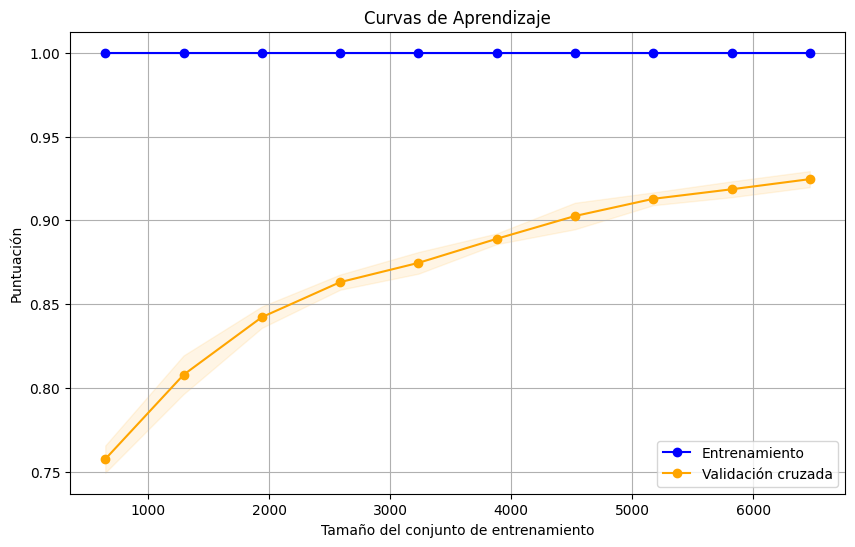

SVC()


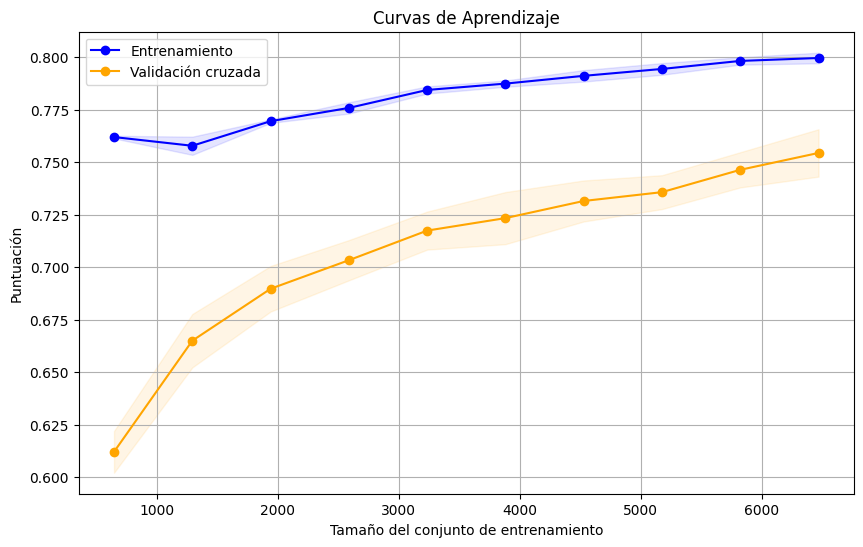

KNeighborsClassifier()


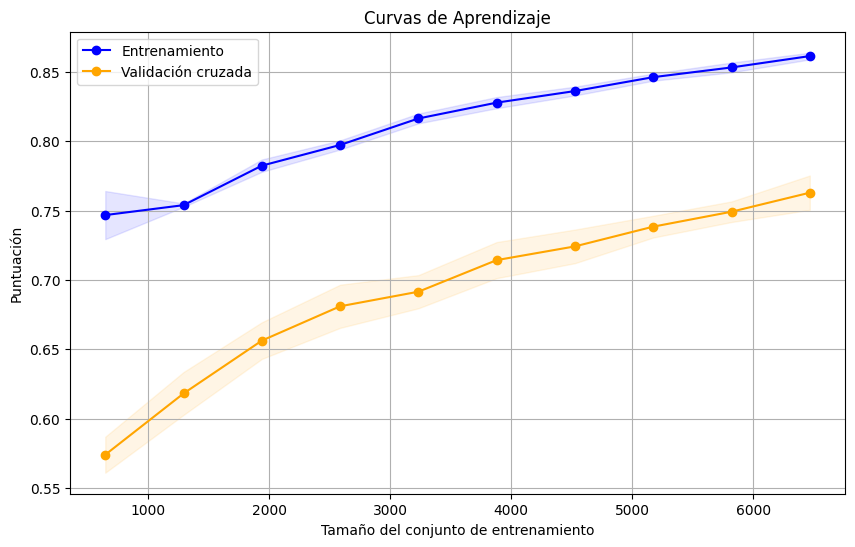

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


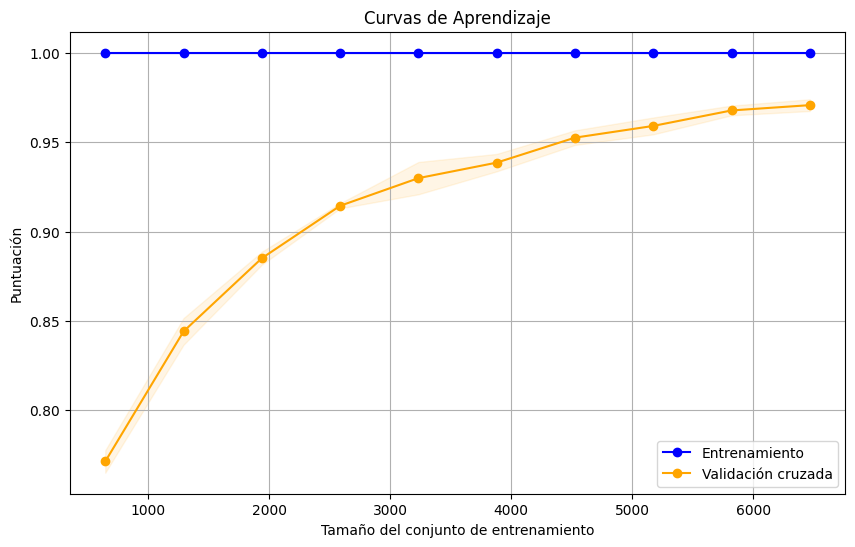

In [60]:
for item in [model_rf, model_svc, model_knn, model_xgbc]:
    print(item)
    graficar(item, x, y)

En estos graficos podemos observar que los modelos tienen tendencia a aprender mas mientras mas datos tiene, por lo cual si agregaramos mas datos al set de datos, podriamos incrementar el accuracy de los modelos.

# Testeo de XGBoost

In [65]:
modelo_final = gscv_model_xgbc.get_params()['estimator']
modelo_final.fit(x, y)
prediccion = modelo_final.predict(X_test)

In [68]:
accuracy_score(prediccion, y_test)

0.5170370370370371

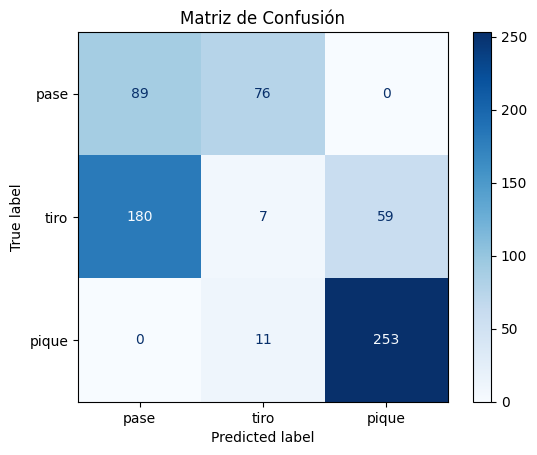

In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

map_labels = {0: 'pique', 1: 'pase', 2: 'tiro'}

y_test_m = pd.Series(y_test).map(map_labels)
prediccion_m = pd.Series(prediccion).map(map_labels)

y_true = y_test_m
y_pred = prediccion_m

matriz_conf = confusion_matrix(y_true, y_pred, labels=['pase', 'tiro', 'pique'])

disp = ConfusionMatrixDisplay(matriz_conf, display_labels=['pase', 'tiro', 'pique'])
disp.plot(cmap='Blues')

plt.title("Matriz de Confusión")
plt.show()


In [78]:
y.value_counts()

movimiento
0    3212
1    2454
2    2419
Name: count, dtype: int64

# Conclusion

Al probar el modelo con datos no vistos anteriormente este nos da un accuracy del 51% por lo cual procedi a analizar las predicciones con una matriz de confusion, en ella podemos observar que el modelo tiende a predecir mayormente a pase y a pique, esto puede ser por falta de datos ya que hay solamente 3.000 datos en pase, y 2.400 en tiro y pique. Agregando datos podria mejorar este mismo, al tener mas variaciones para el aprendizaje del modelo, este podria encontrar algun dato clave para la mejora de la prediccion. En las curvas de aprendizaje se pudo observar tendencia a incrementar la acertividad cuando entrenamos el modelo con mas datos.